In [ ]:
# %pip install imblearn 
# %pip install lightgbm 
# %pip install s3fs
# %pip install seaborn

### Nicole Roberts, Deep Sea Asset Management Case Study, November 2024

# IMPORTS #

In [90]:
from sklearn import datasets

# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
import random
import matplotlib as plt
import matplotlib.pyplot as plt
#import hvplot.pandas

# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
#from evolutionary_search import EvolutionaryAlgorithmSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier


# Importing classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import packages for hyperparameters tuning
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#Libraries for Saving the Model
from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')


# import pyspark

# import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler
# import SMOTE from imblearn
from imblearn.over_sampling import SMOTE 

# Build the lightgbm model
import lightgbm as ltb
from lightgbm import LGBMClassifier

# import catboost
# from catboost import CatBoostClassifier

from sklearn.utils.class_weight import compute_sample_weight

from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.metrics.cluster import adjusted_mutual_info_score


from sklearn.preprocessing import OneHotEncoder

import timeit

In [91]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)  # Adjust as needed

# DATA PRE-PROCESSING #

In [92]:
# Establishing column names
columns = [
'age'
, 'class_of_worker'	#0			
, 'industry_code'	#1				
, 'occupation_code'	 #2			
#, 'agi' 				
, 'education'			#3		
, 'wage_p_hour'			#4		
, 'recently_enrolled_in_education'  #5			
, 'marital_status'				#6
, 'major_industry_code'			#7	
, 'major_occupation_code'		#8		
, 'race'						#9
, 'hispanic_origin'				#10
, 'sex'						#11
, 'labor_union_member'			#12
, 'unemployment_reason'			#13
, 'employment_status'		#14
, 'capital_gains'			#15		
, 'capital_losses'				#16
, 'stock_dividends' 				#17
, 'tax_filer_status'				#18
, 'previous_residence_region'			#19
, 'previous_residence_state'			#20
, 'detailed_household_family_status'		#21
, 'detailed_household_summary'	#22
, 'instance_weight'				#23
, 'migration_code_change_in_msa'	#24		
, 'migration_code_change_in_reg'		#25	
, 'migration_code_move_within_reg'		#26
, 'same_house_one_year_ago'			#27
, 'migration_prev_res_in_sunbelt'		#28	
, 'employer_company_size'		#29
, 'family_members_under_18'			#30
#, 'total_person_earnings'				
, 'country_of_birth_father'			#31
, 'country_of_birth_mother'			#32
, 'country_of_birth'			#33
, 'citizenship'					#34
#, 'total_person_income'			#35	
, 'self_employed'			#36
#, 'taxable_income_amount'				
, 'veterans_admin'	#37
, 'veterans_benefits'	#38			
, 'weeks_worked_in_year'	#39
, 'year' #40
, 'target' #41
    ]

In [93]:
# Function to load and preprocess data
def load_and_preprocess_data(filepath, columns):
    bucket='censusbureau'
    data_key = filepath
    data_location = 's3://{}/{}'.format(bucket, data_key)
    df = pd.read_csv(data_location, header=None)
    df.columns = columns
    df.dropna(inplace=True)
    return df


# Function for checking for potentially problematic characters
def preprocessing(df):

    # Check if there are blank fields or another character
    blanks = lambda x: x == ""
    unknowns = lambda x: x == ' ?'
    
    # Apply the lambda function to the df
    blank = df.applymap(blanks)
    unknown = df.applymap(unknowns)
   
    # Count prevalence
    total_blank = blank.sum().sum()
    total_unknown = unknown.sum().sum()
    print(f"Total number of blank strings: {total_blank}")
    print(f"Total number of unknowns: {total_unknown}")


# Function for calculating Cramers V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Function for calculating categorical variable percentages split by income class (for entire population)
def category_perc_comparison(df, col):
    return pd.crosstab(df[col], df['target'], df['instance_weight'], aggfunc='sum', normalize='index')
        

In [94]:
train = pd.read_csv('./Resources/census_income_learn.csv') #load_and_preprocess_data('census_income_learn.csv', columns) 

test = pd.read_csv('./Resources/census_income_test.csv')

train.columns = columns
train.dropna(inplace=True)

test.columns = columns
test.dropna(inplace=True)

print(train.shape)
test.shape

(199522, 42)


(99761, 42)

In [95]:
train.sort_values(['class_of_worker', 'age'])

,age,class_of_worker,industry_code,occupation_code,education,wage_p_hour,recently_enrolled_in_education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,unemployment_reason,employment_status,capital_gains,capital_losses,stock_dividends,tax_filer_status,previous_residence_region,previous_residence_state,detailed_household_family_status,detailed_household_summary,instance_weight,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,same_house_one_year_ago,migration_prev_res_in_sunbelt,employer_company_size,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth,citizenship,self_employed,veterans_admin,veterans_benefits,weeks_worked_in_year,year,target
52977,15,Federal government,44,31,7th and 8th grade,0,Not in universe,Never married,Social services,Other service,White,All other,Female,Not in universe,Re-entrant,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,299.98,Nonmover,Nonmover,Nonmover,Yes,Not in universe,6,Mother only present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,12,94,- 50000.
140811,15,Federal government,40,12,7th and 8th grade,1000,Not in universe,Never married,Entertainment,Professional specialty,White,All other,Male,No,Not in universe,Full-time schedules,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1254.94,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
171034,16,Federal government,33,41,7th and 8th grade,0,High school,Never married,Retail trade,Handlers equip cleaners etc,White,All other,Female,Not in universe,Re-entrant,Unemployed part- time,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,2964.64,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
16061,17,Federal government,33,41,11th grade,0,High school,Never married,Retail trade,Handlers equip cleaners etc,White,All other,Female,No,Not in universe,Full-time schedules,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1645.08,?,?,?,Not in universe under 1 year old,?,6,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,8,95,- 50000.
23352,17,Federal government,51,46,10th grade,0,High school,Never married,Armed Forces,Armed Forces,White,Other Spanish,Male,Not in universe,Job leaver,Unemployed part- time,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,933.03,?,?,?,Not in universe under 1 year old,?,0,Mother only present,Dominican-Republic,Dominican-Republic,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152919,67,Without pay,42,26,High school graduate,0,Not in universe,Married-civilian spouse present,Medical except hospital,Adm support including clerical,Asian or Pacific Islander,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Joint one under 65 & one 65+,Not in universe,Not in universe,Householder,Householder,1423.82,Nonmover,Nonmover,Nonmover,Yes,Not in universe,2,Not in universe,Philippines,Philippines,Philippines,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
38575,68,Without pay,2,44,Some college but no degree,0,Not in universe,Married-spouse absent,Agriculture,Farm

In [96]:
print(f'Train shape is {train.shape}.')
print(f'Test shape is {test.shape}.')

Train shape is (199522, 42).
Test shape is (99761, 42).


In [97]:
train.target.value_counts()

target
 - 50000.    187140
 50000+.      12382
Name: count, dtype: int64

In [98]:
test.target.value_counts()

target
 - 50000.    93575
 50000+.      6186
Name: count, dtype: int64

In [99]:
#train.dtypes

In [100]:
#test.dtypes

In [101]:
train.detailed_household_family_status.value_counts()

detailed_household_family_status
 Householder                                        53248
 Child <18 never marr not in subfamily              50326
 Spouse of householder                              41695
 Nonfamily householder                              22213
 Child 18+ never marr Not in a subfamily            12030
 Secondary individual                                6122
 Other Rel 18+ ever marr not in subfamily            1955
 Grandchild <18 never marr child of subfamily RP     1868
 Other Rel 18+ never marr not in subfamily           1728
 Grandchild <18 never marr not in subfamily          1066
 Child 18+ ever marr Not in a subfamily              1013
 Child under 18 of RP of unrel subfamily              732
 RP of unrelated subfamily                            685
 Child 18+ ever marr RP of subfamily                  671
 Other Rel <18 never marr child of subfamily RP       656
 Other Rel 18+ ever marr RP of subfamily              656
 Other Rel 18+ spouse of subfamily RP  

In [102]:
train.loc[train['detailed_household_family_status'] == 'Other Rel <18 ever marr RP of subfamily', 'detailed_household_family_status'] = 'Other Rel <18 never married RP of subfamily'
test.loc[test['detailed_household_family_status'] == 'Other Rel <18 ever marr RP of subfamily', 'detailed_household_family_status'] = 'Other Rel <18 never married RP of subfamily'

train.loc[train['detailed_household_family_status'] == ' Grandchild <18 ever marr not in subfamily', 'detailed_household_family_status'] = 'Grandchild <18 never marr not in subfamily'
test.loc[test['detailed_household_family_status'] == ' Grandchild <18 ever marr not in subfamily ', 'detailed_household_family_status'] = 'Grandchild <18 never marr not in subfamily'

# Drop rows where 'detailed_household_family_status' contains 'Grandchild'
train = train[~train['detailed_household_family_status'].str.contains('Grandchild', case=False, na=False)]
test = test[~test['detailed_household_family_status'].str.contains('Grandchild', case=False, na=False)]


In [103]:
train.detailed_household_family_status.value_counts()

detailed_household_family_status
 Householder                                       53248
 Child <18 never marr not in subfamily             50326
 Spouse of householder                             41695
 Nonfamily householder                             22213
 Child 18+ never marr Not in a subfamily           12030
 Secondary individual                               6122
 Other Rel 18+ ever marr not in subfamily           1955
 Other Rel 18+ never marr not in subfamily          1728
 Child 18+ ever marr Not in a subfamily             1013
 Child under 18 of RP of unrel subfamily             732
 RP of unrelated subfamily                           685
 Child 18+ ever marr RP of subfamily                 671
 Other Rel <18 never marr child of subfamily RP      656
 Other Rel 18+ ever marr RP of subfamily             656
 Other Rel 18+ spouse of subfamily RP                638
 Child 18+ never marr RP of subfamily                589
 Other Rel <18 never marr not in subfamily           58

In [104]:
test.detailed_household_family_status.value_counts()

detailed_household_family_status
 Householder                                       26691
 Child <18 never marr not in subfamily             24990
 Spouse of householder                             20654
 Nonfamily householder                             11243
 Child 18+ never marr Not in a subfamily            6134
 Secondary individual                               3156
 Other Rel 18+ ever marr not in subfamily           1021
 Other Rel 18+ never marr not in subfamily           834
 Child 18+ ever marr Not in a subfamily              465
 Child 18+ ever marr RP of subfamily                 354
 Other Rel 18+ spouse of subfamily RP                354
 Child under 18 of RP of unrel subfamily             353
 RP of unrelated subfamily                           340
 Other Rel 18+ ever marr RP of subfamily             310
 Child 18+ never marr RP of subfamily                309
 Other Rel <18 never marr not in subfamily           303
 Other Rel <18 never marr child of subfamily RP      30

In [105]:
train.veterans_benefits.value_counts()

veterans_benefits
2    149416
0     44752
1      1982
Name: count, dtype: int64

In [106]:
# Count duplicates
num_train_duplicates = train.duplicated().sum()
num_test_duplicates = test.duplicated().sum()

print(f'Total percent of duplicated rows in the training dataset: {round(num_train_duplicates/len(train)*100, 1)}%.') 
print(f'Total percent of duplicated rows in the test dataset: {round(num_test_duplicates/len(test)*100, 1)}%.') 

# Drop duplicates
train_no_dups = train.drop_duplicates()
test_no_dups = test.drop_duplicates()

Total percent of duplicated rows in the training dataset: 1.6%.
Total percent of duplicated rows in the test dataset: 0.9%.


In [107]:
# Check if there are duplicates when train and test are combined (merges on all columns)

combo_df = pd.merge(train_no_dups, test_no_dups, how='inner')

print(f'There are {combo_df.shape[0]} duplicate rows when train and test datasets are combined.')

There are 2599 duplicate rows when train and test datasets are combined.


In [108]:
# Remove duplicates 

merged_df = test_no_dups.merge(train_no_dups, how = 'outer', indicator=True)

merged_df

,age,class_of_worker,industry_code,occupation_code,education,wage_p_hour,recently_enrolled_in_education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,unemployment_reason,employment_status,capital_gains,capital_losses,stock_dividends,tax_filer_status,previous_residence_region,previous_residence_state,detailed_household_family_status,detailed_household_summary,instance_weight,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,same_house_one_year_ago,migration_prev_res_in_sunbelt,employer_company_size,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth,citizenship,self_employed,veterans_admin,veterans_benefits,weeks_worked_in_year,year,target,_merge
0,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,White,All other,Female,Not in universe,Not in universe,PT for econ reasons usually PT,0,0,2500,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,1462.33,?,?,?,Not in universe under 1 year old,?,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.,left_only
1,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1601.75,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.,left_only
2,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,Not in universe,Not in universe,Householder,Householder,1866.88,Nonmover,Nonmover,Nonmover,Yes,Not in universe,5,Not in universe,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.,left_only
3,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Single,Not in universe,Not in universe,Secondary individual,Nonrelative of householder,1394.54,?,?,?,Not in universe under 1 year old,?,4,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.,left_only
4,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,2556.34,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,Germany,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287617,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.27,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,right_only
287618,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-c

In [109]:
# Take the merged dataframe and filter only those that are in the test dataset ('left_only') to get a test dataset void of any duplicates
# Drop the extra column created from the merge

test_clean = merged_df.loc[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)

train_clean = train_no_dups.copy()

test_clean.shape

(94661, 42)

In [110]:
preprocessing(train_clean)

Total number of blank strings: 0
Total number of unknowns: 402078


In [111]:
preprocessing(test_clean)

Total number of blank strings: 0
Total number of unknowns: 197743


In [112]:
train_clean.self_employed.value_counts()

self_employed
0    174193
2     16077
1      2691
Name: count, dtype: int64

In [113]:
# Change numerical categories to descriptive strings
train_clean.loc[train_clean.self_employed == 0, 'self_employed'] = 'Not self-employed'
train_clean.loc[train_clean.self_employed == 1, 'self_employed'] = 'Self-employed inc'
train_clean.loc[train_clean.self_employed == 2, 'self_employed'] = 'Self-employed non-inc'

test_clean.loc[test_clean.self_employed == 0, 'self_employed'] = 'Not self-employed'
test_clean.loc[test_clean.self_employed == 1, 'self_employed'] = 'Self-employed inc'
test_clean.loc[test_clean.self_employed == 2, 'self_employed'] = 'Self-employed non-inc'

display(train_clean.self_employed.value_counts())
test_clean.self_employed.value_counts()

self_employed
Not self-employed        174193
Self-employed non-inc     16077
Self-employed inc          2691
Name: count, dtype: int64

self_employed
Not self-employed        85122
Self-employed non-inc     8200
Self-employed inc         1339
Name: count, dtype: int64

In [114]:
# Change numerical categories to descriptive strings
train_clean.loc[train_clean.veterans_benefits == 0, 'veterans_benefits'] = 'Non-veteran'
train_clean.loc[train_clean.veterans_benefits == 1, 'veterans_benefits'] = 'Veteran'
train_clean.loc[train_clean.veterans_benefits == 2, 'veterans_benefits'] = 'N/A'

test_clean.loc[test_clean.veterans_benefits == 0, 'veterans_benefits'] = 'Non-veteran'
test_clean.loc[test_clean.veterans_benefits == 1, 'veterans_benefits'] = 'Veteran'
test_clean.loc[test_clean.veterans_benefits == 2, 'veterans_benefits'] = 'N/A'

train_clean.loc[train_clean.target == ' - 50000.', 'target'] = '<=$100K'
train_clean.loc[train_clean.target == ' 50000+.', 'target'] = '>$100K'
test_clean.loc[test_clean.target == ' - 50000.', 'target'] = '<=$100K'
test_clean.loc[test_clean.target == ' 50000+.', 'target'] = '>$100K'

# Use for later
train_eda = train_clean.copy()
test_eda = test_clean.copy()

# Put in numerical form for machine learning classes
train_clean.loc[train_clean.target == '<=$100K', 'target'] = 0
train_clean.loc[train_clean.target == '>$100K', 'target'] = 1
test_clean.loc[test_clean.target == '<=$100K', 'target'] = 0
test_clean.loc[test_clean.target == '>$100K', 'target'] = 1

In [115]:
train_clean.target.value_counts()

target
0    180582
1     12379
Name: count, dtype: int64

In [116]:
# Convert nominal fields that are presently integer type to string type

train_clean['industry_code'] = train_clean['industry_code'].astype(str)
test_clean['industry_code'] = test_clean['industry_code'].astype(str)

train_clean['occupation_code'] = train_clean['occupation_code'].astype(str)
test_clean['occupation_code'] = test_clean['occupation_code'].astype(str)

train_clean['year'] = train_clean['year'].astype(str)
test_clean['year'] = test_clean['year'].astype(str)

# EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING

## Continuous Features

In [117]:
# Join train and test for EDA section

df = pd.concat([train_eda, test_eda]).reset_index(drop=True)

In [118]:
df

,age,class_of_worker,industry_code,occupation_code,education,wage_p_hour,recently_enrolled_in_education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,unemployment_reason,employment_status,capital_gains,capital_losses,stock_dividends,tax_filer_status,previous_residence_region,previous_residence_state,detailed_household_family_status,detailed_household_summary,instance_weight,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,same_house_one_year_ago,migration_prev_res_in_sunbelt,employer_company_size,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth,citizenship,self_employed,veterans_admin,veterans_benefits,weeks_worked_in_year,year,target
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,N/A,52,94,<=$100K
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,Not self-employed,Not in universe,N/A,0,95,<=$100K
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,0,94,<=$100K
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,0,94,<=$100K
4,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,Amer Indian Aleut or Eskimo,All other,Female,No,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,162.61,?,?,?,Not in universe under 1 year old,?,1,Not in universe,Philippines,United-States,United-States,Native- Born in the United States,Self-employed non-inc,Not in universe,N/A,52,95,<=$100K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287617,4,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1335.91,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,0,95,<=$100K
287618,61,Priva

In [119]:
cols = train.columns 

# Continuous variables only
quant = ['age', 'wage_p_hour', 'capital_gains', 'capital_losses', 'stock_dividends', 'employer_company_size', 'weeks_worked_in_year', 'instance_weight']
quantitative = list(filter(lambda x: x in quant, cols))

In [120]:
quant_df = df[quantitative]

quant_df

,age,wage_p_hour,capital_gains,capital_losses,stock_dividends,instance_weight,employer_company_size,weeks_worked_in_year
0,58,0,0,0,0,1053.55,1,52
1,18,0,0,0,0,991.95,0,0
2,9,0,0,0,0,1758.14,0,0
3,10,0,0,0,0,1069.16,0,0
4,48,1200,0,0,0,162.61,1,52
...,...,...,...,...,...,...,...,...
287617,4,0,0,0,0,1335.91,0,0
287618,61,0,0,0,0,2511.11,4,52
287619,24,0,0,0,0,2083.76,2,52
287620,30,0,0,0,0,1680.06,5,52


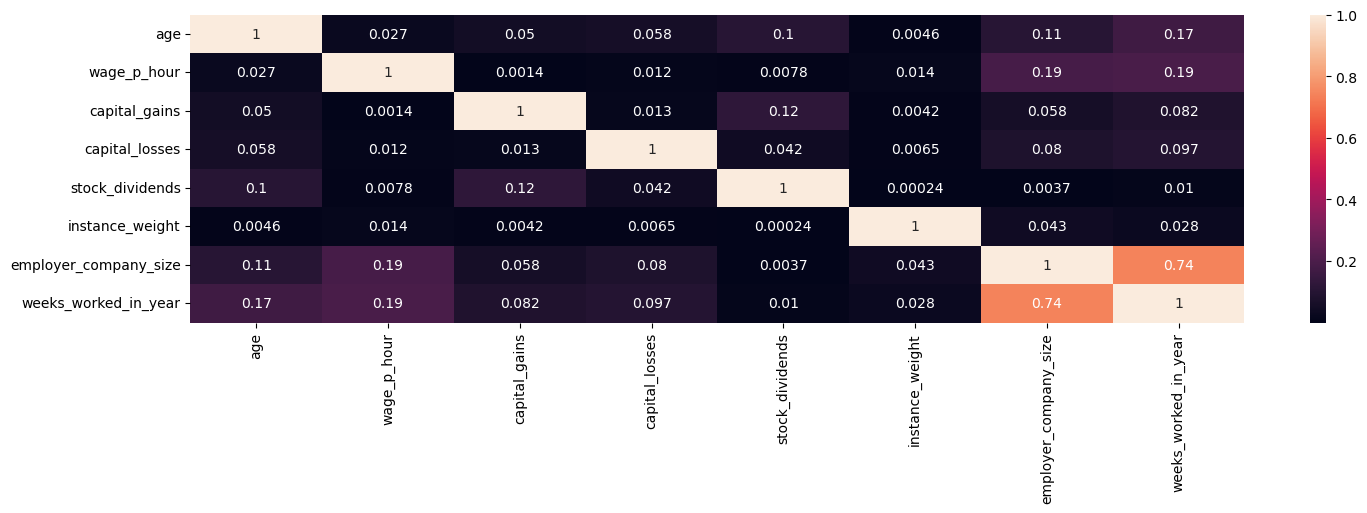

In [121]:
# Checking for multicollinearity

plt.figure(figsize=(17,4))
sns.heatmap(quant_df.corr().abs(), annot=True)
plt.show()

In [122]:
df0 = df.loc[df.target == '<=$100K']
df1 = df.loc[df.target == '>$100K']

In [123]:
tot_pop_over100 = df1.instance_weight.sum()
tot_pop_under100 = df0.instance_weight.sum()

tot_pop_under100

467923145.8100001

In [124]:
df.groupby('target')['target'].count()

target
<=$100K    269058
>$100K      18564
Name: target, dtype: int64

In [125]:
# Check to see if resampling will be needed

target_df = df.target.value_counts(normalize=True).to_frame()

# Create labels from the index to use for plot
labels = target_df.index

target_df

,proportion
target,
<=$100K,0.935457
>$100K,0.064543


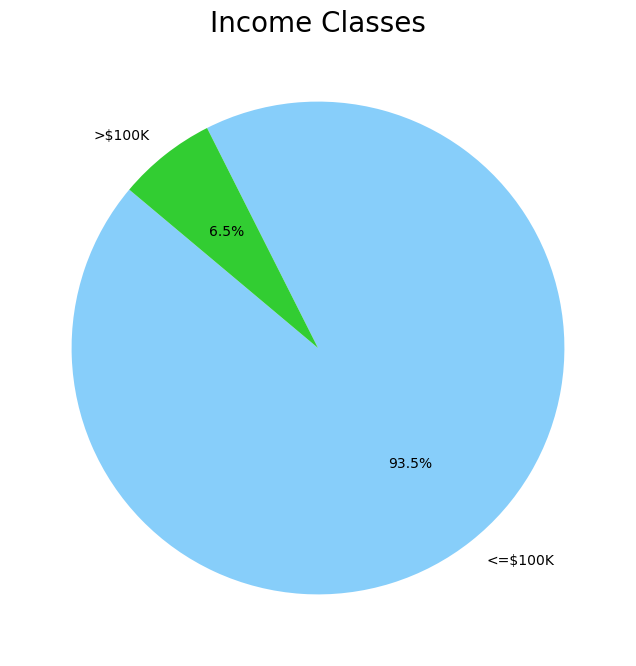

In [126]:
# Pie chart for target

# Custom colors
colors = ['lightskyblue', 'limegreen']

plt.figure(figsize=(8, 8))  # Optional: set the size of the figure
plt.pie(target_df['proportion'], labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Income Classes', fontsize=20)
plt.show()

In [127]:
# Check for correlation between continuous features and target 
# 0.00 - 0.10: Weak or No Relationship. The correlation is very weak, suggesting little to no association between the variables.
# 0.10 - 0.30: Small Association. There is a small but noticeable relationship.
# 0.30 - 0.50: Moderate Association. The relationship is moderate, indicating a moderate association.
# > 0.50: Strong Association. There is a strong relationship between the variables.

# Switch target to numerical values for Point Biserial Correlation (required)
df.loc[df.target == '<=$100K', 'target'] = 0
df.loc[df.target == '>$100K', 'target'] = 1

r, p = pointbiserialr(df['age'], df['target'])
print(f"Point Biserial Correlation of AGE is: {round(r, 2)}, p-value: {round(p, 2)}")

r, p = pointbiserialr(df['weeks_worked_in_year'], df['target'])
print(f"Point Biserial Correlation of WEEKS WORKED IN A YEAR is: {round(r, 2)}, p-value: {round(p, 2)}")

r, p = pointbiserialr(df['employer_company_size'], df['target'])
print(f"Point Biserial Correlation of EMPLOYER COMPANY SIZE is: {round(r, 2)}, p-value: {round(p, 2)}")

r, p = pointbiserialr(df['capital_gains'], df['target'])
print(f"Point Biserial Correlation of CAPITAL GAINS is: {round(r, 2)}, p-value: {round(p, 2)}")

r, p = pointbiserialr(df['capital_losses'], df['target'])
print(f"Point Biserial Correlation of CAPITAL LOSSES is: {round(r, 2)}, p-value: {round(p, 2)}")

r, p = pointbiserialr(df['wage_p_hour'], df['target'])
print(f"Point Biserial Correlation of WAGE P. HOUR is: {round(r, 2)}, p-value: {round(p, 2)}")

r, p = pointbiserialr(df['stock_dividends'], df['target'])
print(f"Point Biserial Correlation of STOCK DIVIDENDS is: {round(r, 2)}, p-value: {round(p, 2)}")


# Switch back to more interpretable target notation
df.loc[df.target == 0, 'target'] = '<=$100K'
df.loc[df.target == 1, 'target'] = '>$100K'

Point Biserial Correlation of AGE is: 0.13, p-value: 0.0
Point Biserial Correlation of WEEKS WORKED IN A YEAR is: 0.26, p-value: 0.0
Point Biserial Correlation of EMPLOYER COMPANY SIZE is: 0.22, p-value: 0.0
Point Biserial Correlation of CAPITAL GAINS is: 0.24, p-value: 0.0
Point Biserial Correlation of CAPITAL LOSSES is: 0.15, p-value: 0.0
Point Biserial Correlation of WAGE P. HOUR is: 0.02, p-value: 0.0
Point Biserial Correlation of STOCK DIVIDENDS is: 0.18, p-value: 0.0


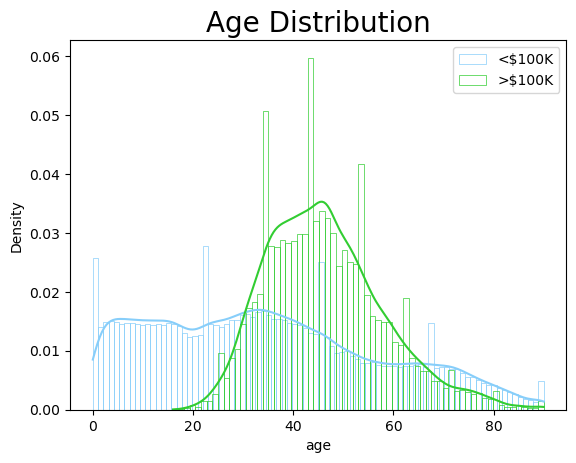

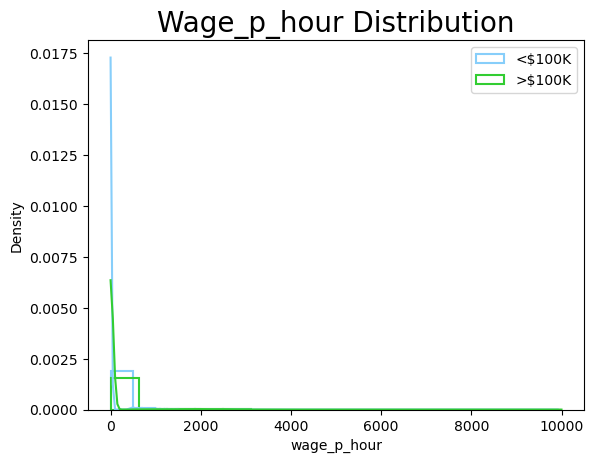

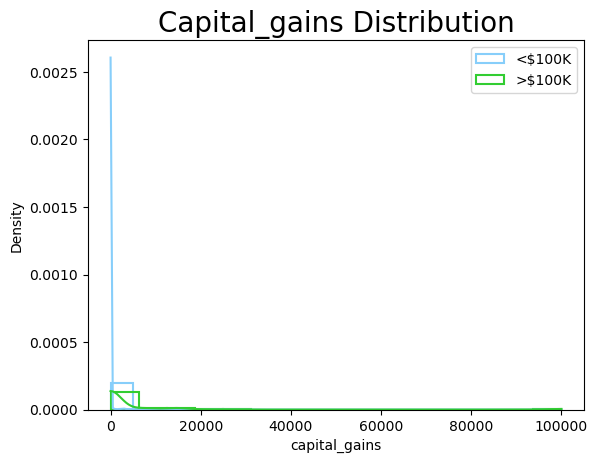

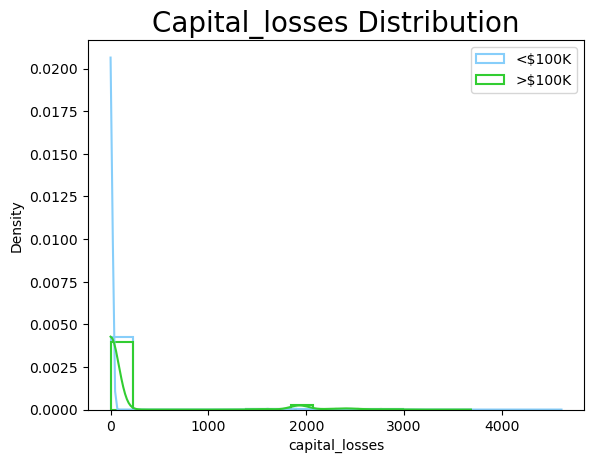

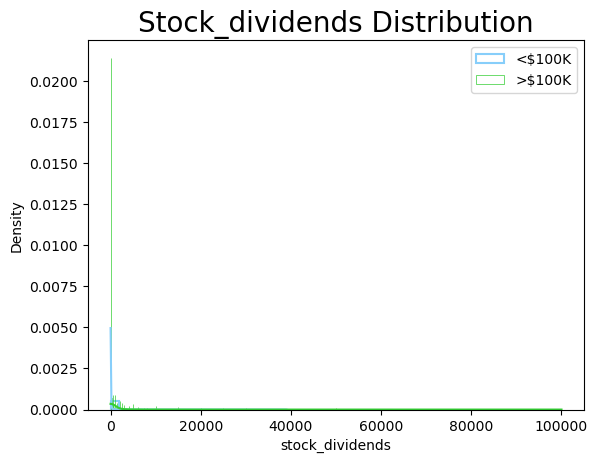

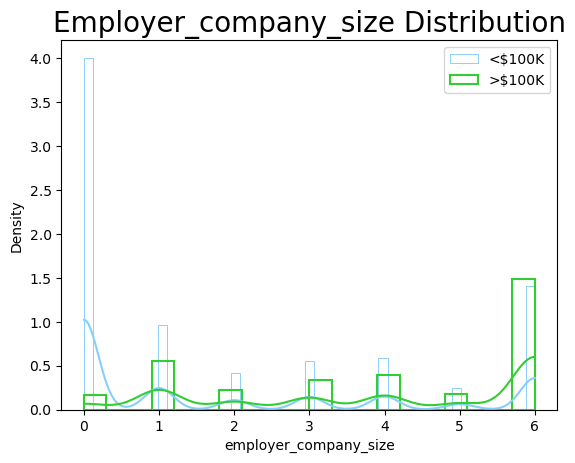

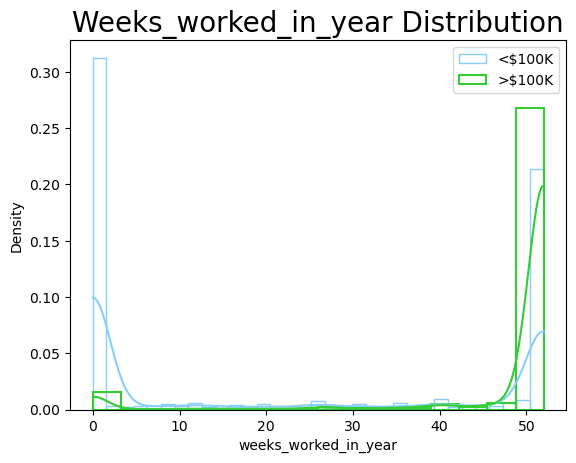

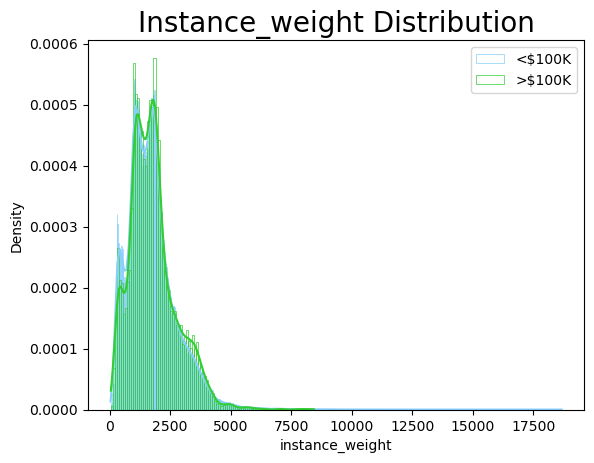

In [128]:
# Checking for class dependencies, ordinal data, and features that can be reduced to classes 

for col in quant:
    
    # Create histograms for both datasets
    sns.histplot(df0[col], color='lightskyblue', label='<$100K', kde=True, fill=False, stat="density", common_norm=False) 
    sns.histplot(df1[col], color='limegreen', label='>$100K', kde=True, fill=False, stat="density", common_norm=False) 
    
    # Add legend
    plt.legend()

    plt.title(col.capitalize() + ' Distribution', fontsize=20)
    
    # Show the plot
    plt.show()

### Further Analysis: Employer Company Size

Employer Company Size is in fact an ordinal variable. 

In [129]:
# Convert to an ordinal variable
train_clean = train_clean.assign(employer_company_size_cat=lambda x: x['employer_company_size'].map({
    0 : 'Not in universe', 1 : '<10', 2 : '10 - 24', 3 : '25 - 99', 4 : '100 - 499', 5 : '500 - 999', 6 : '1000+'})).drop('employer_company_size', axis=1).rename(columns={'employer_company_size_cat': 'employer_company_size'})

test_clean = test_clean.assign(employer_company_size_cat=lambda x: x['employer_company_size'].map({
    0 : 'Not in universe', 1 : '<10', 2 : '10 - 24', 3 : '25 - 99', 4 : '100 - 499', 5 : '500 - 999', 6 : '1000+'})).drop('employer_company_size', axis=1).rename(columns={'employer_company_size_cat': 'employer_company_size'})

df = df.assign(employer_company_size_cat=lambda x: x['employer_company_size'].map({
    0 : 'Not in universe', 1 : '<10', 2 : '10 - 24', 3 : '25 - 99', 4 : '100 - 499', 5 : '500 - 999', 6 : '1000+'})).drop('employer_company_size', axis=1).rename(columns={'employer_company_size_cat': 'employer_company_size'})

In [130]:
test0 = df.groupby(['target', 'employer_company_size'])['employer_company_size'].count().to_frame()

test0

employer_company_size
target  employer_company_size                       
<=$100K 10 - 24                                13848
        100 - 499                              19178
        1000+                                  46328
        25 - 99                                18323
        500 - 999                               7922
        <10                                    31558
        Not in universe                       131901
>$100K  10 - 24                                 1232
        100 - 499                               2199
        1000+                                   8265
        25 - 99                                 1870
        500 - 999                               1008
        <10                                     3084
        Not in universe                          906

In [131]:
test1 = test0.unstack()

test1

employer_company_size                           \
employer_company_size               10 - 24 100 - 499  1000+ 25 - 99   
target                                                                 
<=$100K                               13848     19178  46328   18323   
>$100K                                 1232      2199   8265    1870   

                                                        
employer_company_size 500 - 999    <10 Not in universe  
target                                                  
<=$100K                    7922  31558          131901  
>$100K                     1008   3084             906

In [132]:
df.employer_company_size.value_counts()

employer_company_size
Not in universe    132807
1000+               54593
<10                 34642
100 - 499           21377
25 - 99             20193
10 - 24             15080
500 - 999            8930
Name: count, dtype: int64

In [133]:
# Take into account the instance weight field to get actual sums of people in each group 

tento24 = df.instance_weight.loc[(df['employer_company_size'] == '10 - 24') & (df['target'] == '<=$100K')].sum()
onehundto499 = df.instance_weight.loc[(df['employer_company_size'] == '100 - 499') & (df['target'] == '<=$100K')].sum()
thousplus = df.instance_weight.loc[(df['employer_company_size'] == '1000+') & (df['target'] == '<=$100K')].sum()
twetfiveto99 = df.instance_weight.loc[(df['employer_company_size'] == '25 - 99') & (df['target'] == '<=$100K')].sum()
fivehundto999 = df.instance_weight.loc[(df['employer_company_size'] == '500 - 999') & (df['target'] == '<=$100K')].sum()
lessthan10 = df.instance_weight.loc[(df['employer_company_size'] == '<10') & (df['target'] == '<=$100K')].sum()
notinuni = df.instance_weight.loc[(df['employer_company_size'] == 'Not in universe') & (df['target'] == '<=$100K')].sum()

tento24_2 = df.instance_weight.loc[(df['employer_company_size'] == '10 - 24') & (df['target'] == '>$100K')].sum()
onehundto499_2 = df.instance_weight.loc[(df['employer_company_size'] == '100 - 499') & (df['target'] == '>$100K')].sum()
thousplus_2 = df.instance_weight.loc[(df['employer_company_size'] == '1000+') & (df['target'] == '>$100K')].sum()
twetfiveto99_2 = df.instance_weight.loc[(df['employer_company_size'] == '25 - 99') & (df['target'] == '>$100K')].sum()
fivehundto999_2 = df.instance_weight.loc[(df['employer_company_size'] == '500 - 999') & (df['target'] == '>$100K')].sum()
lessthan10_2 = df.instance_weight.loc[(df['employer_company_size'] == '<10') & (df['target'] == '>$100K')].sum()
notinuni_2 = df.instance_weight.loc[(df['employer_company_size'] == 'Not in universe') & (df['target'] == '>$100K')].sum()

listCompUnder100 = [tento24, onehundto499, thousplus, twetfiveto99, fivehundto999, lessthan10, notinuni]
listCompOver100 = [tento24_2, onehundto499_2, thousplus_2, twetfiveto99_2, fivehundto999_2, lessthan10_2, notinuni_2]

listCompUnder100

[24200121.380000003,
 33958155.730000004,
 84160073.33,
 32164441.19,
 14266290.809999999,
 54005281.14000001,
 225168782.23]

In [134]:
test2 = test1.T

test2

target                                       <=$100K  >$100K
                      employer_company_size                 
employer_company_size 10 - 24                  13848    1232
                      100 - 499                19178    2199
                      1000+                    46328    8265
                      25 - 99                  18323    1870
                      500 - 999                 7922    1008
                      <10                      31558    3084
                      Not in universe         131901     906

In [135]:
test3 = test2.reset_index().drop(columns='level_0')

test3

target,employer_company_size,<=$100K,>$100K
0,10 - 24,13848,1232
1,100 - 499,19178,2199
2,1000+,46328,8265
3,25 - 99,18323,1870
4,500 - 999,7922,1008
5,<10,31558,3084
6,Not in universe,131901,906


In [136]:
test3['people_under_100K'] = listCompUnder100
test3['people_over_100K'] = listCompOver100

test3

target,employer_company_size,<=$100K,>$100K,people_under_100K,people_over_100K
0,10 - 24,13848,1232,2.420012e+07,2156812.34
1,100 - 499,19178,2199,3.395816e+07,4005226.31
2,1000+,46328,8265,8.416007e+07,14965928.70
3,25 - 99,18323,1870,3.216444e+07,3281080.65
4,500 - 999,7922,1008,1.426629e+07,1798734.37
5,<10,31558,3084,5.400528e+07,5427455.47
6,Not in universe,131901,906,2.251688e+08,1599598.51


In [137]:
test3.people_under_100K.sum() + test3.people_over_100K.sum()

501157982.16

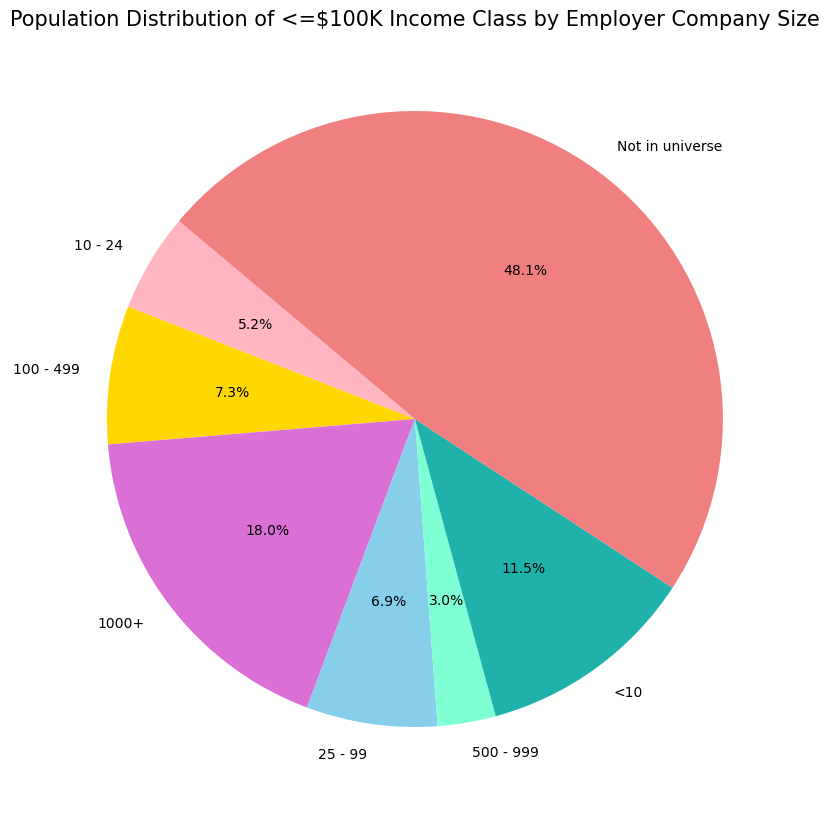

In [138]:
colors = ['lightpink', 'gold', 'orchid', 'skyblue', 'aquamarine', 'lightseagreen', 'lightcoral']

# Extracting the values for the <=$100K group
labels = test3['employer_company_size']
sizes = test3['people_under_100K']

# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Population Distribution of <=$100K Income Class by Employer Company Size', fontsize=15)
plt.show()

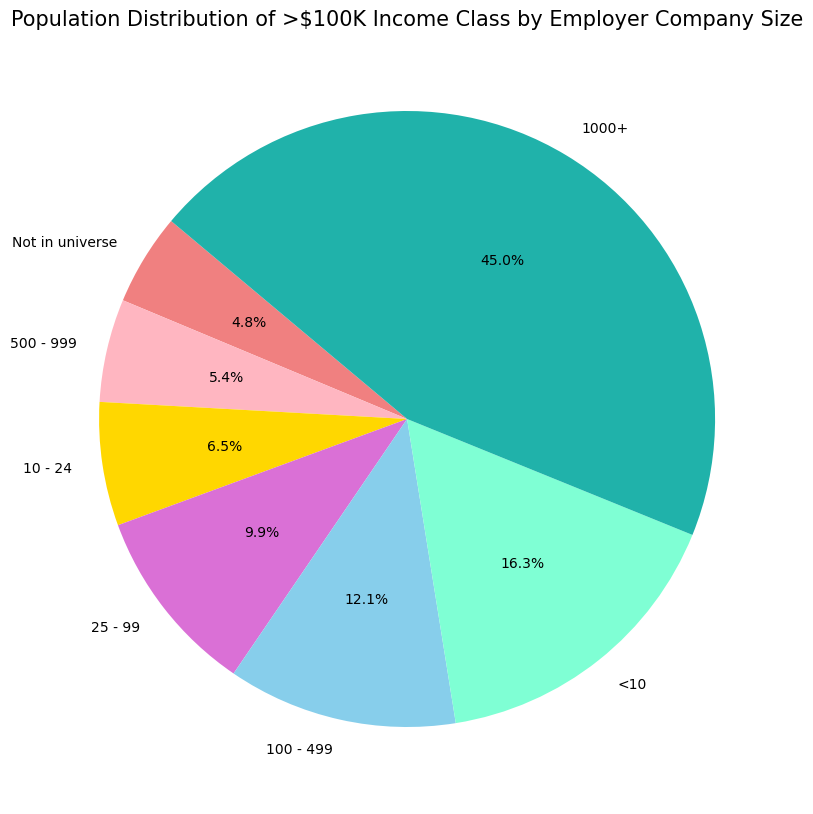

In [139]:
test3 = test3.sort_values('>$100K', ascending=True)

colors = ['lightcoral', 'lightpink', 'gold', 'orchid', 'skyblue', 'aquamarine', 'lightseagreen']

# Extracting the values for the <= $50K group
labels = test3['employer_company_size']
sizes = test3['people_over_100K']

# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Population Distribution of >$100K Income Class by Employer Company Size', fontsize=15)
plt.show()

### Further Analysis: Age

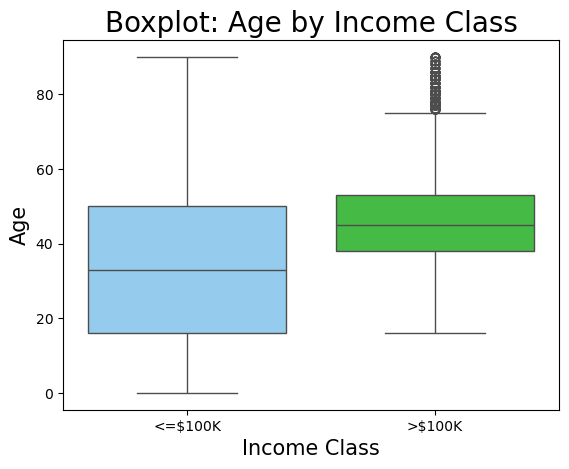

In [140]:
colors = ['lightskyblue', 'limegreen'] 

# Create a boxplot with categorical data
sns.boxplot(x='target', y='age', data=df, palette=colors)

# Add a title
plt.title('Boxplot: Age by Income Class', fontsize=20)

# Add an x-axis label
plt.xlabel('Income Class', fontsize=15)

# Add an y-axis label
plt.ylabel('Age', fontsize=15)

# Show the plot
plt.show()

In [141]:
# Examine quantiles
df.groupby(by=['target'])['age'].quantile([0, 0.10, 0.25, 0.5, 0.75, 0.90, 1]).to_frame().rename_axis(index={None: 'Quantile'}).T

target   <=$100K                                    >$100K                    \
Quantile    0.00 0.10  0.25  0.50  0.75  0.90  1.00   0.00  0.10  0.25  0.50   
age          0.0  6.0  16.0  33.0  50.0  68.0  90.0   16.0  32.0  38.0  45.0   

target                      
Quantile  0.75  0.90  1.00  
age       53.0  62.0  90.0

100K and under begins at birth and covers the entire age range; 50% of groups are between 25 years old and 52 years old. 
Over 100k begins at age 16 and goes until the end of the age range (90); 50% of gropus are between 38 and 43 years old (more concentrated).

### Further Analysis: Capital Gains & Losses

In [142]:
# colors = ['lightseagreen', 'gold'] 

# # Create a boxplot 
# sns.boxplot(x='target', y='capital_gains', data=df, palette=colors)

# # Add a title
# plt.title('Boxplot: Capital Gains by Income Class', fontsize=15)

# # Add an x-axis label
# plt.xlabel('Income Class', fontsize=15)

# # Add an y-axis label
# plt.ylabel('Capital Gains', fontsize=15)

# # Show the plot
# plt.show()



# # Create a boxplot 
# sns.boxplot(x='target', y='capital_losses', data=df, palette=colors)

# # Add a title
# plt.title('Boxplot: Capital Losses by Income Class', fontsize=15)

# # Add an x-axis label
# plt.xlabel('Income Class', fontsize=15)

# # Add an y-axis label
# plt.ylabel('Capital Losses', fontsize=15)

# # Show the plot
# plt.show()

In [143]:
no_cap_gain = df['capital_gains'].loc[df.capital_gains == 0].count()/df['capital_gains'].count()
no_cap_loss = df['capital_losses'].loc[df.capital_losses == 0].count()/df['capital_losses'].count()

print(f'The percent of people who have no capital gains to report are {round(no_cap_gain*100,1)}%.')
print(f'The percent of people who have no capital losses to report are {round(no_cap_loss*100,1)}%.')

The percent of people who have no capital gains to report are 96.1%.
The percent of people who have no capital losses to report are 98.0%.


### Further Analysis: Stock Dividends

In [144]:
# # Create a boxplot 
# sns.boxplot(x='target', y='stock_dividends', data=df, palette=colors)

# # Add a title
# plt.title('Boxplot: Stock Dividends by Income Class', fontsize=15)

# # Show the plot
# plt.show()

In [145]:
no_stock_dividends = df['stock_dividends'].loc[df.stock_dividends == 0].count()/df['stock_dividends'].count()

print(f'The percent of people who have no stock dividends to report are {round(no_stock_dividends*100,1)}%.')

The percent of people who have no stock dividends to report are 89.0%.


### Further Analysis: Weeks Worked p. Year

In [146]:
# Split weeks_worked_in_year into ordinal values (not working, part-time, full-time)

# First ensure numeric
train_clean['weeks_worked_in_year'] = pd.to_numeric(train_clean['weeks_worked_in_year'], errors='coerce') 
test_clean['weeks_worked_in_year'] = pd.to_numeric(test_clean['weeks_worked_in_year'], errors='coerce') 
df['weeks_worked_in_year'] = pd.to_numeric(df['weeks_worked_in_year'], errors='coerce') 

# Create new categorical variable for weeks worked in yar
train_clean.loc[train_clean['weeks_worked_in_year'] == 0, 'weeks_worked_in_year_cat'] = 'not working'
test_clean.loc[test_clean['weeks_worked_in_year'] == 0, 'weeks_worked_in_year_cat'] = 'not working'
df.loc[df['weeks_worked_in_year'] == 0, 'weeks_worked_in_year_cat'] = 'not working'

train_clean.loc[(train_clean['weeks_worked_in_year'] > 0) & (train_clean['weeks_worked_in_year'] < 48), 'weeks_worked_in_year_cat'] = 'part-time'
test_clean.loc[(test_clean['weeks_worked_in_year'] > 0) & (test_clean['weeks_worked_in_year'] < 48), 'weeks_worked_in_year_cat'] = 'part-time'
df.loc[(df['weeks_worked_in_year'] > 0) & (df['weeks_worked_in_year'] < 48), 'weeks_worked_in_year_cat'] = 'part-time'

train_clean.loc[train_clean['weeks_worked_in_year'] >= 48, 'weeks_worked_in_year_cat'] = 'full-time'
test_clean.loc[test_clean['weeks_worked_in_year'] >= 48, 'weeks_worked_in_year_cat'] = 'full-time'
df.loc[df['weeks_worked_in_year'] >= 48, 'weeks_worked_in_year_cat'] = 'full-time'

train_clean.drop(columns='weeks_worked_in_year', inplace=True)
test_clean.drop(columns='weeks_worked_in_year', inplace=True)
df.drop(columns='weeks_worked_in_year', inplace=True)

train_clean.rename(columns={'weeks_worked_in_year_cat':'weeks_worked_in_year'}, inplace=True)
test_clean.rename(columns={'weeks_worked_in_year_cat':'weeks_worked_in_year'}, inplace=True)
df.rename(columns={'weeks_worked_in_year_cat':'weeks_worked_in_year'}, inplace=True)


In [147]:
weeks = df.groupby(by=['target', 'weeks_worked_in_year'])['weeks_worked_in_year'].count().to_frame()

weeks2 = weeks.unstack()

weeks2

weeks_worked_in_year                      
weeks_worked_in_year            full-time not working part-time
target                                                         
<=$100K                             96978      131901     40179
>$100K                              16414         906      1244

In [148]:
full_time = df.instance_weight.loc[(df['weeks_worked_in_year'] == 'full-time') & (df['target'] == '<=$100K')].sum()
not_working = df.instance_weight.loc[(df['weeks_worked_in_year'] == 'not working') & (df['target'] == '<=$100K')].sum()
part_time = df.instance_weight.loc[(df['weeks_worked_in_year'] == 'part-time') & (df['target'] == '<=$100K')].sum()

full_time_2 = df.instance_weight.loc[(df['weeks_worked_in_year'] == 'full-time') & (df['target'] == '>$100K')].sum()
not_working_2 = df.instance_weight.loc[(df['weeks_worked_in_year'] == 'not working') & (df['target'] == '>$100K')].sum()
part_time_2 = df.instance_weight.loc[(df['weeks_worked_in_year'] == 'part-time') & (df['target'] == '>$100K')].sum()

listHoursUnder100 = [full_time, not_working, part_time]
listHoursOver100 = [full_time_2, not_working_2, part_time_2]

listCompUnder100


[24200121.380000003,
 33958155.730000004,
 84160073.33,
 32164441.19,
 14266290.809999999,
 54005281.14000001,
 225168782.23]

In [149]:
weeks3 = weeks2.T

weeks4 = weeks3.reset_index().drop(columns=['level_0'])

weeks4

target,weeks_worked_in_year,<=$100K,>$100K
0,full-time,96978,16414
1,not working,131901,906
2,part-time,40179,1244


In [150]:
weeks4['people_under_100K'] = listHoursUnder100
weeks4['people_over_100K'] = listHoursOver100

weeks4

target,weeks_worked_in_year,<=$100K,>$100K,people_under_100K,people_over_100K
0,full-time,96978,16414,1.709650e+08,29420628.36
1,not working,131901,906,2.251688e+08,1599598.51
2,part-time,40179,1244,7.178934e+07,2214609.48


In [151]:
# # Pie chart for hours worked for <=$100K

# # Custom colors
# colors = ['lightseagreen', 'lightpink', 'gold']

# categories = ['full-time', 'not working', 'part-time']
# less_than_equal_100k = weeks4['people_under_100K']

# # Plotting the pie chart for <= $100K
# plt.figure(figsize=(10, 10))
# plt.pie(less_than_equal_100k, labels=categories, autopct='%1.1f%%', startangle=140, colors=colors)
# plt.title('Population Distribution of <=$100K Income Class by Weeks Worked in Year', fontsize=20)
# plt.show()


# # Pie chart for target for >$100K

# categories = ['full-time', 'not working', 'part-time']
# greater_than_100k = weeks4['people_over_100K']

# # Plotting the pie chart for <= $50K
# plt.figure(figsize=(10, 10))
# plt.pie(greater_than_100k, labels=categories, autopct='%1.1f%%', startangle=140, colors=colors)
# plt.title('Population Distribution of >$100K Income Class by Weeks Worked in Year', fontsize=20)
# plt.show()

Observe <=$100K is more evenly distributed.

## Categorical Features

In [152]:
quant_revised = ['age', 'wage_p_hour', 'capital_gains', 'capital_losses', 'stock_dividends']
columns = df.columns
cats_cols = list(filter(lambda x: x not in quant_revised, columns))  # Selecting everything that is not a continuous variable

In [153]:
cats = train_clean[cats_cols]

#pd.get_dummies(nominals_only)
#cols = cats.columns.to_list()

cats_cols

['class_of_worker',
 'industry_code',
 'occupation_code',
 'education',
 'recently_enrolled_in_education',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'labor_union_member',
 'unemployment_reason',
 'employment_status',
 'tax_filer_status',
 'previous_residence_region',
 'previous_residence_state',
 'detailed_household_family_status',
 'detailed_household_summary',
 'instance_weight',
 'migration_code_change_in_msa',
 'migration_code_change_in_reg',
 'migration_code_move_within_reg',
 'same_house_one_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth',
 'citizenship',
 'self_employed',
 'veterans_admin',
 'veterans_benefits',
 'year',
 'target',
 'employer_company_size',
 'weeks_worked_in_year']

In [154]:
train_clean.to_csv('./Resources/trainingready.csv', index=False)
test_clean.to_csv('./Resources/testready.csv', index=False)
cats.to_csv('./Resources/categoricalvariables.csv', index=False)

In [155]:
cats.groupby(by=['sex', 'target'])['sex'].count()

sex      target
 Female  0         98068
         1          2663
 Male    0         82514
         1          9716
Name: sex, dtype: int64

In [156]:
cats.groupby(by=['target', 'sex'])['sex'].count()

target  sex    
0        Female    98068
         Male      82514
1        Female     2663
         Male       9716
Name: sex, dtype: int64

In [157]:
# This gives prevalance in population (instance weight applied)

weighted_freq = pd.crosstab(df['sex'], df['target'], df['instance_weight'], aggfunc='sum', normalize='index')

print(weighted_freq)

target    <=$100K    >$100K
sex                        
 Female  0.972540  0.027460
 Male    0.892837  0.107163


In [158]:
males = df['instance_weight'].loc[df.sex == ' Male'].sum()
females = df['instance_weight'].loc[df.sex == ' Female'].sum()

# Apply two filters (gender and income bracket) and sum the number of people in the population

males_over_100k = df['instance_weight'].loc[(df.sex == ' Male') & (df.target == '>$100K')].sum()
females_over_100k = df['instance_weight'].loc[(df.sex == ' Female') & (df.target == '>$100K')].sum()


print(males_over_100k)
females_over_100k

26181933.009999998


7052903.34

In [159]:
pd.crosstab(df['sex'], df['target'])

target,<=$100K,>$100K
sex,,
Female,146083,3967
Male,122975,14597


In [160]:
# Chi-Square Test of Independence:
# Purpose: To test whether there is a significant association between two categorical variables.
# Application: It measures the independence of two variables by comparing the observed frequencies in a contingency table with the expected frequencies.


# Cramer's V test for categorical variables.
# Purpose: To measure the strength of association between two categorical variables.
# Application: It is a normalized version of the Chi-square statistic and provides a measure between 0 (no association) and 1 (perfect association).
# Implementation: Cramér's V can be calculated from the Chi-square statistic.

# It is not affected by sample size and therefore is very useful in situations where you suspect a statistically significant chi-square was the result of large 
# sample size instead of any substantive relationship between the variables. It is interpreted as a measure of the relative (strength) of an association between 
# two variables. The coefficient ranges from 0 to 1 (perfect association). 

# 𝑉<0.1: negligible
# 0.1<𝑉<0.2: weak
# 0.2<𝑉<0.4: moderate
# 0.4<𝑉<0.6: relatively strong
# 0.6<𝑉<0.8: strong
# 𝑉>0.8: very strong
    

# Mutual Information (MI)
# Mutual Information quantifies the amount of information obtained about one variable through another. It is sensitive to any type of relationship, including linear and nonlinear associations.
# A weak MI score indicates that the feature provides little information about the target, suggesting that the knowledge of the feature does not significantly reduce uncertainty about the target.
# The "adjusted" aspect indicates that the calcualation has been adjusted for what would be expected by random chance.

# Weak Relationship (NMI ≈ 0.0 to 0.3)
# Moderate Relationship (NMI ≈ 0.0 to 0.3)
# Strong Relationship (NMI ≈ 0.0 to 0.3)


cramers_list = []
mutual_info_list = []   

# For each column, create a contingency table and then calculate the Cramer's V score and the Mutual Information score and add to a list
for col in cats_cols:
    contingency_table = pd.crosstab(df[col], df['target'], df['instance_weight'], aggfunc='sum')  # Instance included so looking at entire population
    # chi2, p, dof, ex = chi2_contingency(contingency_table)
    # print(f"Chi2 for {col}: {round(chi2,2)}, p-value: {round(p,3)}")

    # Calculate Cramér's V
    cramer_v_value = cramers_v(contingency_table.values)
    cramers_list.append(round(cramer_v_value,3))

    # Calculate Mutual 
    # Calculate normalized mutual information
    nmi = adjusted_mutual_info_score(df[col], df['target'])
    mutual_info_list.append(round(nmi,3))

In [161]:
contingency_table

target,<=$100K,>$100K
weeks_worked_in_year,,
full-time,1.709650e+08,29420628.36
not working,2.251688e+08,1599598.51
part-time,7.178934e+07,2214609.48


In [162]:
cramers_scores = pd.DataFrame(data=cramers_list, index=cats_cols, columns=['Cramers V Score']).drop('target')
cramers_scores.sort_values('Cramers V Score', ascending=False).head(20)

,Cramers V Score
occupation_code,0.439
major_occupation_code,0.365
major_industry_code,0.274
weeks_worked_in_year,0.266
class_of_worker,0.256
employer_company_size,0.232
tax_filer_status,0.229
marital_status,0.197
sex,0.160
employment_status,0.157


In [163]:
mutual_info_scores = pd.DataFrame(data=mutual_info_list, index=cats_cols, columns=['Adjusted Mutual Info Score']).drop('target')
mutual_info_scores.sort_values('Adjusted Mutual Info Score', ascending=False).head()

,Adjusted Mutual Info Score
weeks_worked_in_year,0.061
major_occupation_code,0.050
occupation_code,0.047
education,0.045
class_of_worker,0.044


In [164]:
scores = cramers_scores.merge(mutual_info_scores, on=cramers_scores.index)
scores['Weighted Score'] = round((scores['Cramers V Score'] + scores['Adjusted Mutual Info Score'])/2,2)
scores = scores.sort_values('Weighted Score', ascending=False)
scores

,key_0,Cramers V Score,Adjusted Mutual Info Score,Weighted Score
2,occupation_code,0.439,0.047,0.24
7,major_occupation_code,0.365,0.050,0.21
35,weeks_worked_in_year,0.266,0.061,0.16
6,major_industry_code,0.274,0.031,0.15
0,class_of_worker,0.256,0.044,0.15
14,tax_filer_status,0.229,0.040,0.13
34,employer_company_size,0.232,0.035,0.13
5,marital_status,0.197,0.029,0.11
10,sex,0.160,0.030,0.10
13,employment_status,0.157,0.017,0.09



Some features have a strong Cramér's V score with the target  but a very weak Mutual Information (MI) score, suggesting that the relationship between the feature and the target is more complex and possibly nonlinear. 

Interpretation for Strong Cramér's V but Weak MI:

Strong Categorical Association: The feature and the target may have a strong categorical association, suggesting that certain categories of the feature are strongly linked to specific categories of the target.

Non-Informative or Redundant Feature: Despite the strong association indicated by Cramér's V, the feature may not provide significant new information about the target. This can happen if the feature is redundant or if the relationship is not useful for prediction (e.g., if the target distribution is very skewed across categories).

Complex Relationships: The relationship captured by Cramér's V might be complex or involve interactions with other variables. MI may not capture this complexity adequately if the mutual dependency is not straightforward.

Different Sensitivity: Cramér's V is designed to capture the strength of association, regardless of the nature of the relationship, while MI is more focused on the informational content. Therefore, MI might not reflect the same strength of association if the information gain is low.

In [165]:
# cramers_scores.sort_values('Cramers V Score', ascending=False)[:25].plot(kind='bar', figsize=(15,8), color='darkblue', fontsize=12)
# plt.grid(color='gray')
# plt.xticks(rotation=90)  # Rotate labels by 45 degrees
# plt.title('Feature Relationship Strength with Income Class (Cramers V Scores)', fontsize=23)
# plt.ylabel('Cramers V Score')
# plt.show()

In [166]:
# mutual_info_scores.sort_values('Adjusted Mutual Info Score', ascending=False).plot(kind='bar', figsize=(15,8), color='lightseagreen', fontsize=12)
# plt.grid(color='gray')
# plt.xticks(rotation=90)  # Rotate labels by 45 degrees
# plt.title('Amount of Mutual Information with Income Class', fontsize=25)
# plt.ylabel('Adjusted Mutual Info Score')
# plt.show()

In [167]:
cats_cols

['class_of_worker',
 'industry_code',
 'occupation_code',
 'education',
 'recently_enrolled_in_education',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'labor_union_member',
 'unemployment_reason',
 'employment_status',
 'tax_filer_status',
 'previous_residence_region',
 'previous_residence_state',
 'detailed_household_family_status',
 'detailed_household_summary',
 'instance_weight',
 'migration_code_change_in_msa',
 'migration_code_change_in_reg',
 'migration_code_move_within_reg',
 'same_house_one_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth',
 'citizenship',
 'self_employed',
 'veterans_admin',
 'veterans_benefits',
 'year',
 'target',
 'employer_company_size',
 'weeks_worked_in_year']

In [168]:
# Make a copy of the category columns so can make edits down the line
cats_cols_edit = cats_cols

In [169]:
cats_cols_edit.remove('target')

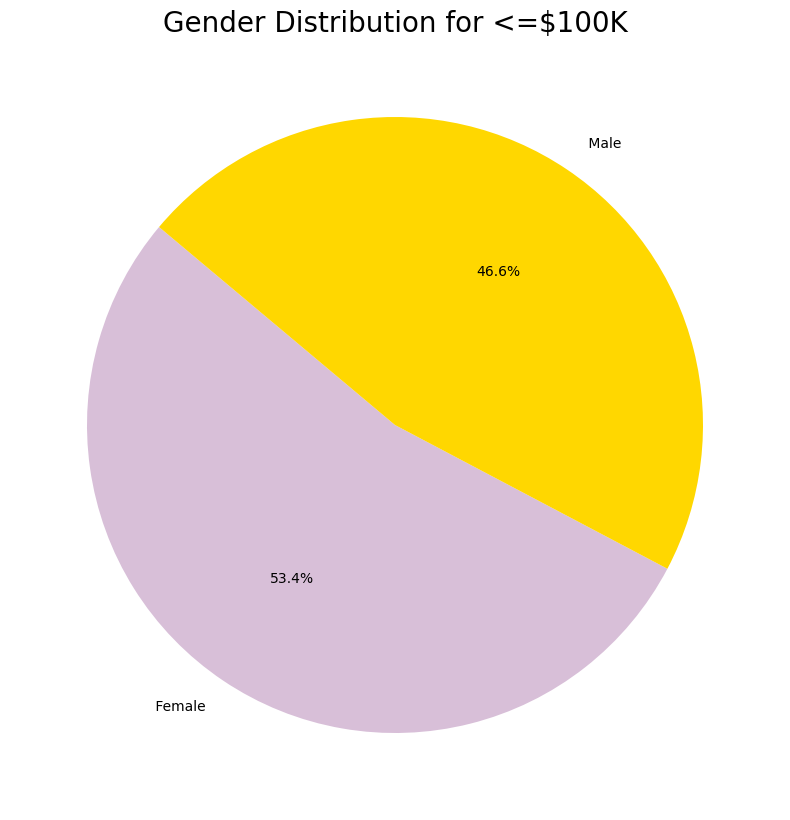

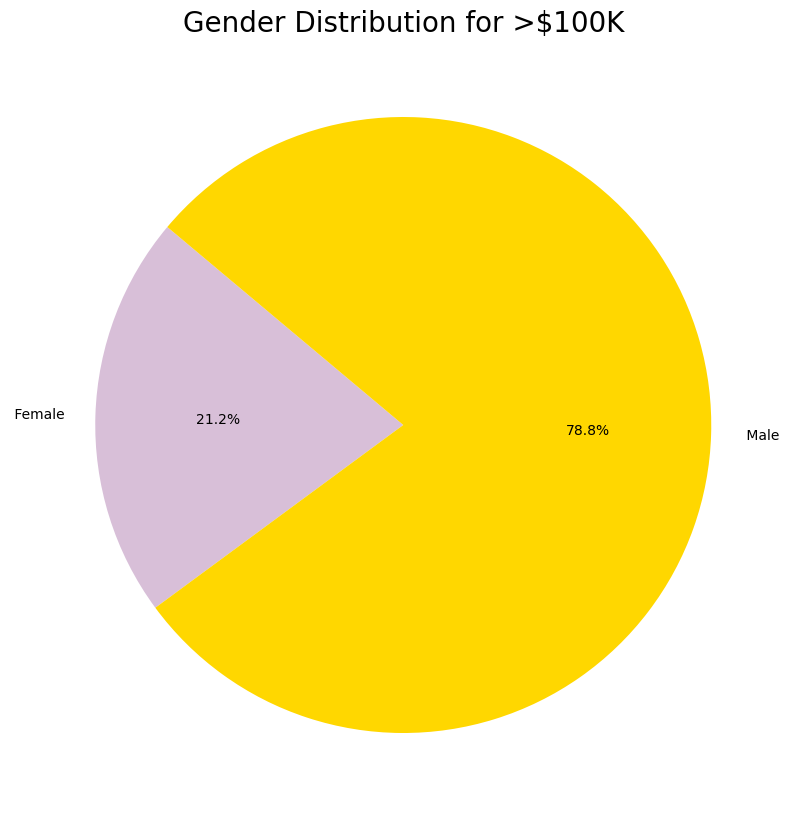

In [170]:
# Define age groups
bins = [0, 20, 30, 40, 50, 60, 100]  # Define age ranges
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# # Create crosstab with age group
# for age_group in df['age_group'].unique():
#     if pd.isna(age_group):  # Skip NaN age groups
#         continue
#     # Filter data for the current age group
#     df_age_group = df[df['age_group'] == age_group]

#     # Crosstab analysis
#     ct = pd.crosstab(df_age_group['sex'], df_age_group['target'], df_age_group['instance_weight'], aggfunc='sum', normalize='index')

#     # Plot the distribution
#     for gender in ct.index:
#         plt.figure(figsize=(8, 6))
#         plt.pie(ct.loc[gender], labels=ct.columns, autopct='%1.1f%%', startangle=140)
#         plt.title(f'Distribution of Income for {gender} in Age Group {age_group}')
#         plt.show()


colors = ['thistle', 'gold']#['lightpink', 'gold', 'thistle', 'skyblue', 'aquamarine', 'lightseagreen', 'lightcoral', 'cornflowerblue', 'grey']
colors2 = ['peachpuff', 'thistle', 'lavender', 'cornflowerblue', 'paleturquoise', 'grey']

#nm_age = df.loc[df['marital_status'] == ' Never married']
ct = pd.crosstab(df['target'], df['sex'], df['instance_weight'], aggfunc='sum', normalize='index')

for i in ct.index:
    plt.figure(figsize=(10, 10))
    plt.pie(ct.loc[i], labels=ct.columns, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f'Gender Distribution for {i}', fontsize=20)
    plt.show()



In [171]:
df.loc[df['marital_status'] == ' Never married']

,age,class_of_worker,industry_code,occupation_code,education,wage_p_hour,recently_enrolled_in_education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,unemployment_reason,employment_status,capital_gains,capital_losses,stock_dividends,tax_filer_status,previous_residence_region,previous_residence_state,detailed_household_family_status,detailed_household_summary,instance_weight,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,same_house_one_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth,citizenship,self_employed,veterans_admin,veterans_benefits,year,target,employer_company_size,weeks_worked_in_year,age_group
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,Not self-employed,Not in universe,N/A,95,<=$100K,Not in universe,not working,0-19
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,94,<=$100K,Not in universe,not working,0-19
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,94,<=$100K,Not in universe,not working,0-19
6,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,White,All other,Female,Not in universe,Job loser - on layoff,Unemployed full-time,0,0,0,Single,Not in universe,Not in universe,Secondary individual,Nonrelative of householder,898.83,?,?,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,N/A,95,<=$100K,100 - 499,part-time,20-29
9,8,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,2466.24,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,94,<=$100K,Not in universe,not working,0-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287612,22,Private,43,26,Some college but no degree,0,College or university,Never married,Education,Adm support including clerical,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Single,Not in universe,Not in universe,Nonfamily householder,Householder,1164.53,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Not in universe,United-States,United-State

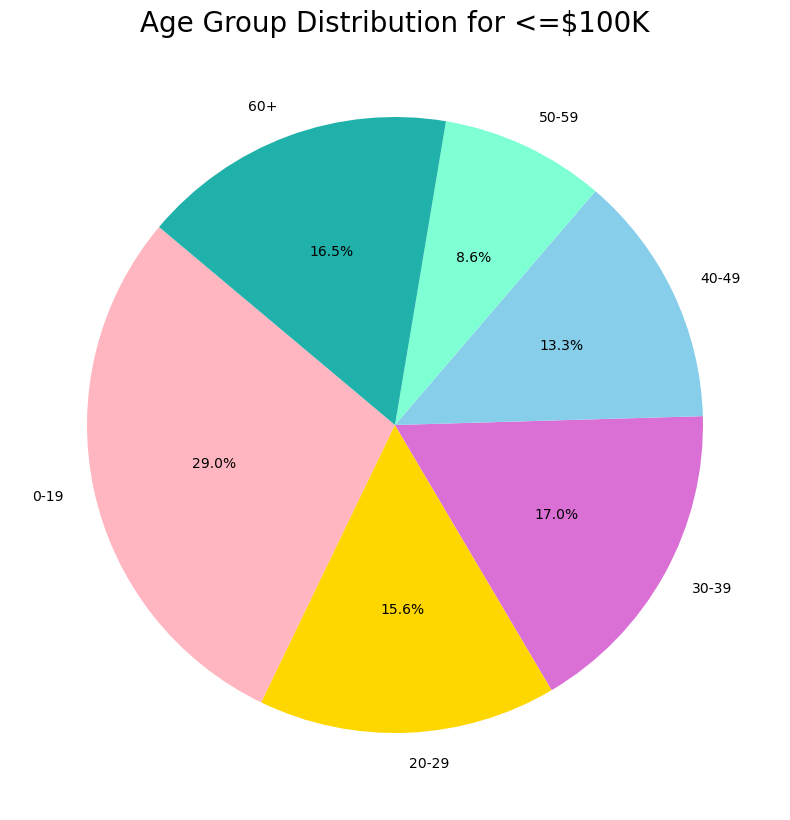

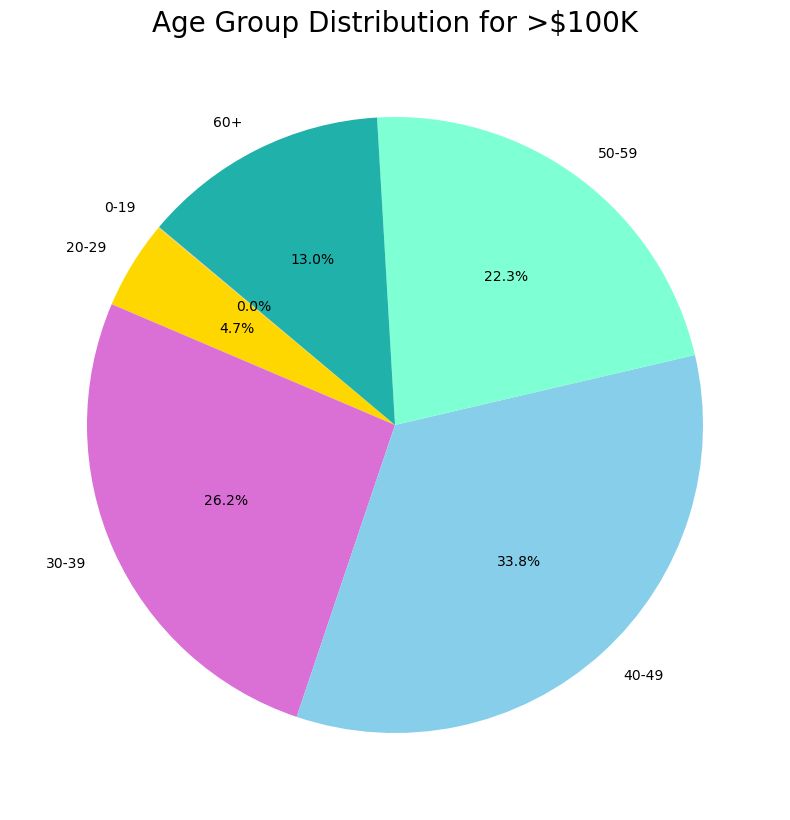

In [172]:
colors = ['lightpink', 'gold', 'orchid', 'skyblue', 'aquamarine', 'lightseagreen', 'lightcoral', 'cornflowerblue', 'thistle']

ct = pd.crosstab(df['target'], df['age_group'], df['instance_weight'], aggfunc='sum', normalize='index')

# Pie chart for each gender category
for target in ct.index:
    plt.figure(figsize=(10, 10))
    plt.pie(ct.loc[target], labels=ct.columns, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f'Age Group Distribution for {target}', fontsize=20)
    plt.show()

In [174]:
# for col in cats_cols_edit:
#     category_perc_comparison(df, col).sort_values('<=$100K', ascending=False).plot(kind='bar', figsize=(10,5), color=['lightskyblue', 'limegreen'], fontsize=12)
#     plt.title(f'Population Income Comparison by {col.capitalize()}', fontsize=20)
#     plt.ylabel('Percentage', fontsize=15)
#     plt.xlabel(col.capitalize(), fontsize=15)
#     plt.show()

# MODELING

### Separate categorical variables from quantitative variables and target variable to enable OneHotEncoding

In [66]:
# Read in training and testing datasets cleaned above
train_clean = pd.read_csv('./Resources/trainingready.csv')
test_clean = pd.read_csv('./Resources/testready.csv')

test_clean

,age,class_of_worker,industry_code,occupation_code,education,wage_p_hour,recently_enrolled_in_education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,unemployment_reason,employment_status,capital_gains,capital_losses,stock_dividends,tax_filer_status,previous_residence_region,previous_residence_state,detailed_household_family_status,detailed_household_summary,instance_weight,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,same_house_one_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth,citizenship,self_employed,veterans_admin,veterans_benefits,year,target,employer_company_size,weeks_worked_in_year
0,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,White,All other,Female,Not in universe,Not in universe,PT for econ reasons usually PT,0,0,2500,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,1462.33,?,?,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,NaN,95,0,<10,part-time
1,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1601.75,?,?,?,Not in universe under 1 year old,?,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,95,0,Not in universe,not working
2,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,Not in universe,Not in universe,Householder,Householder,1866.88,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Self-employed non-inc,Not in universe,NaN,94,0,500 - 999,full-time
3,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Single,Not in universe,Not in universe,Secondary individual,Nonrelative of householder,1394.54,?,?,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,NaN,95,0,100 - 499,full-time
4,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,2556.34,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,Germany,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,94,0,Not in universe,not working
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94656,4,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1335.91,?,?,?,Not in universe under 1 year old,?,Both parents present,United-States,United-States,United-States,Native- Born in the United

In [67]:
# Filter a list of categorical variables only

do_not_want = ['age', 'wage_p_hour', 'capital_gains', 'capital_losses', 'stock_dividends', 'target']
columns = train_clean.columns
cats_cols_edit = list(filter(lambda x: x not in do_not_want, columns))  # Selecting everything that is not a continuous variable

# Get list of quantitative variables only

quants = ['age', 'wage_p_hour', 'capital_gains', 'capital_losses', 'stock_dividends']

In [68]:
# Create new DataFrames with categorical variables only

train_cat = train_clean[cats_cols_edit]
test_cat = test_clean[cats_cols_edit]

# train_cat = train_cat.reset_index(drop=True)
# test_cat = test_cat.reset_index(drop=True)

train_cat

,class_of_worker,industry_code,occupation_code,education,recently_enrolled_in_education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,labor_union_member,unemployment_reason,employment_status,tax_filer_status,previous_residence_region,previous_residence_state,detailed_household_family_status,detailed_household_summary,instance_weight,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,same_house_one_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth,citizenship,self_employed,veterans_admin,veterans_benefits,year,employer_company_size,weeks_worked_in_year
0,Self-employed-not incorporated,4,34,Some college but no degree,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,NaN,94,<10,full-time
1,Not in universe,0,0,10th grade,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,Not self-employed,Not in universe,NaN,95,Not in universe,not working
2,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,94,Not in universe,not working
3,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,Non-veteran,94,Not in universe,not working
4,Private,40,10,Some college but no degree,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,Amer Indian Aleut or Eskimo,All other,Female,No,Not in universe,Full-time schedules,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,162.61,?,?,?,Not in universe under 1 year old,?,Not in universe,Philippines,United-States,United-States,Native- Born in the United States,Self-employed non-inc,Not in universe,NaN,95,<10,full-time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192956,Not in universe,0,0,7th and 8th grade,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.27,?,?,?,Not in universe under 1 year old,?,Not in universe,Canada,United-States,United-States,Native- Born in the United States,Not self-employed,Not in universe,NaN,95,Not in universe,not working
192957,Self-employed-incorporated,37,2,11th grade,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and manag

In [69]:
# Create new DataFrames with quantitative variables only

train_quant = train_clean[quants]
test_quant = test_clean[quants]

# train_quant = train_quant.reset_index(drop=True)
# test_quant = test_quant.reset_index(drop=True)

test_quant

,age,wage_p_hour,capital_gains,capital_losses,stock_dividends
0,44,0,0,0,2500
1,2,0,0,0,0
2,35,0,0,0,0
3,49,0,0,0,0
4,13,0,0,0,0
...,...,...,...,...,...
94656,4,0,0,0,0
94657,61,0,0,0,0
94658,24,0,0,0,0
94659,30,0,0,0,0


In [70]:
train_target = train_clean['target']
train_target = train_target.reset_index(drop=True)

test_target = test_clean['target']
test_target = test_target.reset_index(drop=True)

test_target

0        0
1        0
2        0
3        0
4        0
        ..
94656    0
94657    0
94658    0
94659    0
94660    0
Name: target, Length: 94661, dtype: int64

### Encode categorical variables using OneHotEncoder and concatenating final dataset

In [71]:
encoded_cat_train_df = pd.get_dummies(train_cat)
encoded_cat_test_df = pd.get_dummies(test_cat)

In [72]:
encoded_train_df = encoded_cat_train_df.astype(int)
encoded_test_df = encoded_cat_test_df.astype(int)

In [73]:
# # Instantiate an instance of OneHotEncoder 
# enc_train = OneHotEncoder(sparse_output=False)
# enc_test = OneHotEncoder(sparse_output=False)

In [74]:
# # Fit and transform your training and test categorical datasets (the ones that are to be encoded)
# encoded_train = enc_train.fit_transform(train_cat)
# encoded_test = enc_test.fit_transform(test_cat)

In [75]:
# encoded_train_df = pd.DataFrame(
#     encoded_train,
#     columns = enc_train.get_feature_names_out(cats_cols_edit)
# )

# encoded_test_df = pd.DataFrame(
#     encoded_test,
#     columns = enc_test.get_feature_names_out(cats_cols_edit)
# )


# encoded_train_df = encoded_train_df.reset_index(drop=True)
# encoded_test_df = encoded_test_df.reset_index(drop=True)

In [76]:
train_ready = pd.concat([train_quant, encoded_cat_train_df, train_target], axis=1)  # Will use train_ready in 'sample_weight' parameter in models
test_ready = pd.concat([test_quant, encoded_cat_test_df, test_target], axis=1)

In [77]:
train_ready_final = train_ready.drop(columns='instance_weight')
test_ready_final = test_ready.drop(columns='instance_weight')

In [78]:
# #Use dummy variables to calculate Pearson Correlation Coefficients

# correlation = train_ready_final.corr().abs()
# correlation_df = abs(correlation['target'])

# correlation_df = correlation_df.sort_values(ascending=False).to_frame().drop(index='target')
# correlation_df[:50].plot(kind='bar', figsize=(15,5), color='lightseagreen', fontsize=12)
# plt.xticks(rotation=90)  # Rotate labels by 45 degrees
# plt.grid(color='gray')
# plt.title('Feature Relationship Strength with Income Class (Pearson Correlation Coefficients)', fontsize=20)
# plt.ylabel('Pearson Correlation Coefficient')
# plt.show()

In [79]:
# train_ready_final.to_csv('./Resources/train_ready_final.csv', index=False)
# test_ready_final.to_csv('./Resources/test_ready_final.csv', index=False)

print(train_ready_final.shape)
test_ready_final.shape

(192961, 411)


(94661, 411)

In [80]:
train_ready_final['target'] = pd.to_numeric(train_ready_final['target'], errors='coerce')

test_ready_final['target'] = pd.to_numeric(test_ready_final['target'], errors='coerce')

### Separate predicted variable from features for training dataset

In [81]:
#Separate predicted variable from features for training dataset

y_train = train_ready_final['target']

X_train = train_ready_final.drop(columns='target')

y_test = test_ready_final['target']

X_test = test_ready_final.drop(columns='target')

### Scaling

In [82]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Scale both the training and testing data from the features dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Resampling

In [83]:
# Instantiate the RandomUnderSampler instance
ros = RandomOverSampler(random_state=1)

# Fit the data to the model
X_train_scaled_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

# Count distinct values for the resampled target data
y_train_resampled.value_counts()

target
0    180582
1    180582
Name: count, dtype: int64

In [84]:
# Instantiate the RandomUnderSampler instance
smote = SMOTE(random_state=1, n_jobs=-1)

# Fit the data to the model
X_train_scaled_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Count distinct values for the resampled target data
y_train_resampled.value_counts()

target
0    180582
1    180582
Name: count, dtype: int64

## Model Construction

### Random Forest

In [85]:
t_0 = timeit.default_timer()

# Random Forest

#weights = {0:1.0, 1:20}
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, bootstrap=True) #class_weight='balanced' #n_estimators=100, max_features=5, max_depth=20, min_samples_split=5, min_samples_leaf=1, bootstrap=False)
rf_model.fit(X_train_scaled, y_train, sample_weight=train_ready.instance_weight) 


predictions = rf_model.predict(X_test_scaled)

print(accuracy_score(y_test, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predictions, average='weighted')))

print(confusion_matrix(y_test, predictions))

t_1 = timeit.default_timer()

elapsed_time = round((t_1 - t_0),3)
print(f"Elapsed time: {elapsed_time/60} min.")

0.9485955145202354
Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.83
Macro Recall: 0.68
Macro F1-score: 0.73

Weighted Precision: 0.94
Weighted Recall: 0.95
Weighted F1-score: 0.94
[[87544   932]
 [ 3934  2251]]
Elapsed time: 0.9129166666666666 min.


In [86]:
print(classification_report(y_test, predictions, target_names=["<=$100K", ">$100k"]))

print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

      <=$50K       0.96      0.99      0.97     88476
       >$50k       0.71      0.36      0.48      6185

    accuracy                           0.95     94661
   macro avg       0.83      0.68      0.73     94661
weighted avg       0.94      0.95      0.94     94661

[[87544   932]
 [ 3934  2251]]


In [87]:
pred_proba = rf_model.predict_proba(X_test_scaled)

#Get ROC AUC score

roc_auc_score(y_test, pred_proba[:,1])

0.9328503255138308

### XGBoost

In [107]:
#Establish XGB model instance


# {'colsample_bytree': 0.735806546529098, 'gamma': 1.0845337072571217, 'max_depth': 17.0, 'min_child_weight': 2.0, 'reg_alpha': 40.0, 'reg_lambda': 0.13367311015317085}
params = {
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 4,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  #.9 Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
   # 'gamma': 1.0845337072571217, 
    #'reg_alpha': 25.0, 
    #'reg_lambda': 0.13367311015317085
}

# Calculate scale_pos_weight
neg = sum(y_train == 0)
pos = sum(y_train == 1)
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)    #colsample_bytree=0.8480792835232346, gamma=8.919043498341008, max_depth=10, min_child_weight=7.0, reg_alpha=43, reg_lambda=0.23572509008184162) 

#Fit training dataset to model
xgb_model.fit(X_train_scaled, y_train, sample_weight=train_ready.instance_weight)

#Predicting on validation set

predictions = xgb_model.predict(X_test_scaled)

print(accuracy_score(y_test, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predictions, average='weighted')))

print(confusion_matrix(y_test, predictions))

0.946112971551114
Weighted Precision: 0.94
Weighted Recall: 0.95
Weighted F1-score: 0.94
[[86594  1882]
 [ 3219  2966]]


In [108]:
print(classification_report(y_test, predictions, target_names=["<=$50K", ">$50k"]))

print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

      <=$50K       0.96      0.98      0.97     88476
       >$50k       0.61      0.48      0.54      6185

    accuracy                           0.95     94661
   macro avg       0.79      0.73      0.75     94661
weighted avg       0.94      0.95      0.94     94661

[[86594  1882]
 [ 3219  2966]]


In [109]:
pred_proba = xgb_model.predict_proba(X_test_scaled)

#Get ROC AUC score

roc_auc_score(y_test, pred_proba[:,1])

0.9413640538758477

### Logistic Regression

In [ ]:
t_0 = timeit.default_timer()

# Logistic Regression

#weights = {0:1.0, 1:20}
lr_model = LogisticRegression(class_weight='balanced', penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga', max_iter=10000)
lr_model.fit(X_train_scaled, y_train, sample_weight=train_ready.instance_weight) 


predictions = rf_model.predict(X_test_scaled)

print(accuracy_score(y_test, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predictions, average='weighted')))

print(confusion_matrix(y_test, predictions))

t_1 = timeit.default_timer()

elapsed_time = round((t_1 - t_0),3)
print(f"Elapsed time: {elapsed_time/60} min.")

In [ ]:
print(classification_report(y_test, predictions, target_names=["<=$50K", ">$50k"]))

print(confusion_matrix(y_test, predictions))

In [ ]:
pred_proba = lr_model.predict_proba(X_test_scaled)

#Get ROC AUC score

roc_auc_score(y_test, pred_proba[:,1])

## Determining Feature Importance 

In [88]:
#Feature importances

importances = rf_model.feature_importances_

important_features = zip(X_test.columns, rf_model.feature_importances_)

importances_df = pd.DataFrame(important_features)

importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

importances_df = importances_df.set_index('Feature')

importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df['cumulative_importance'] = importances_df['Importance'].cumsum()

cutoff = importances_df.loc[importances_df['cumulative_importance'] >= 0.950000]

extraneous_cols = cutoff.index.to_list()

Text(0.5, 1.0, 'Feature Importance')

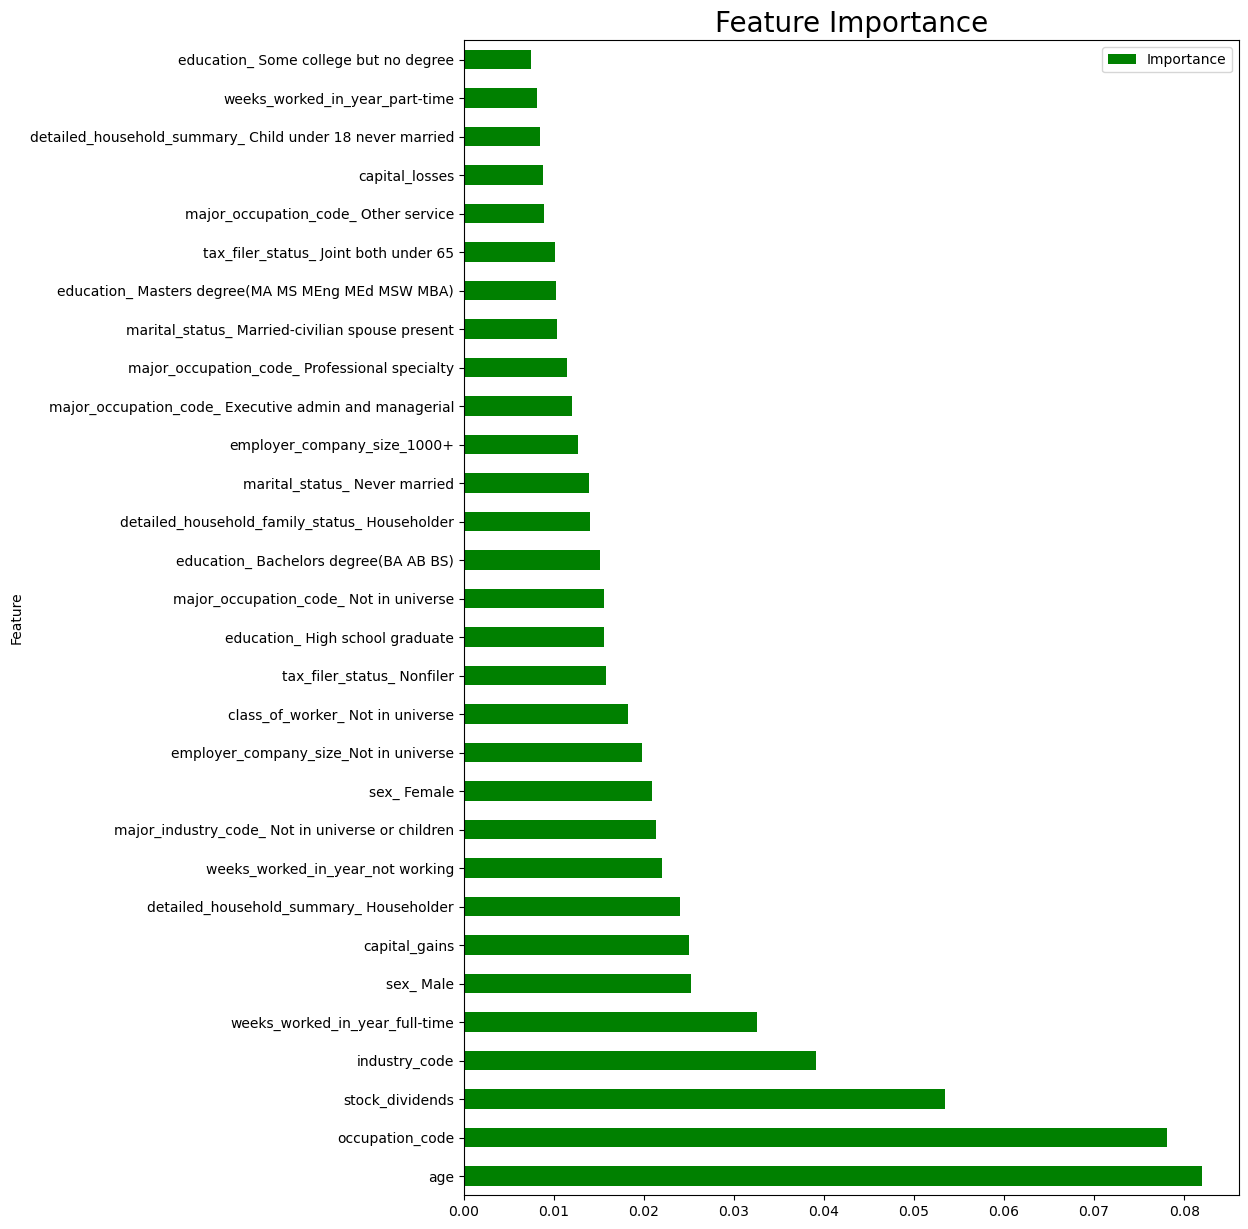

In [89]:
#Plot the top 10 most important features

importances_df.Importance[0:30].plot(
    kind='barh',
    color='green',
    figsize=(10, 15),
    legend=True).set_title('Feature Importance', fontsize=20) 

# Model Tuning

## Hyperparameter Tuning for Random Forest

In [ ]:
t_0 = timeit.default_timer()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {}

paramgrid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=RandomForestClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X_train_scaled, y_train, sample_weight=train_ready.instance_weight)

t_1 = timeit.default_timer()

elapsed_time = round((t_1 - t_0),3)
print(f"Elapsed time: {elapsed_time/60} min.")